In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST,EMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

/home/bikasherl/miniconda3/envs/bajra/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## EMNIST Dataset

In [2]:
train_edata=EMNIST(root='emnist_dataset/train/',split='balanced',train=True,download=True,transform=ToTensor())
test_edata=EMNIST(root='emnist_dataset/test/',split='balanced',train=False,download=True,transform=ToTensor())
train_edata,test_edata

(Dataset EMNIST
     Number of datapoints: 112800
     Root location: emnist_dataset/train/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset EMNIST
     Number of datapoints: 18800
     Root location: emnist_dataset/test/
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Train and Test Set Preparation

In [3]:
#train set
X_etrain=torch.flatten(train_edata.data,1,2).to(torch.float32)/255
Y_etrain=train_edata.targets.reshape(X_etrain.shape[0],1).to(torch.int8)

# test set
X_etest=torch.flatten(test_edata.data,1,2).to(torch.float32)/255
Y_etest=test_edata.targets.reshape(X_etest.shape[0],1).to(torch.int8)

X_etrain.shape,Y_etrain.shape,X_etest.shape,Y_etest.shape

(torch.Size([112800, 784]),
 torch.Size([112800, 1]),
 torch.Size([18800, 784]),
 torch.Size([18800, 1]))

In [4]:
## One hot encoding For the labels

Y_enc_etrain=torch.zeros((Y_etrain.shape[0],len(train_edata.classes))).to(torch.int8)

for i in range(Y_etrain.shape[0]):
    Y_enc_etrain[i][Y_etrain[i].item()]=1


Y_enc_etest=torch.zeros((Y_etest.shape[0],len(test_edata.classes))).to(torch.int8)

for i in range(Y_etest.shape[0]):
    Y_enc_etest[i][Y_etest[i].item()]=1


Y_enc_etrain.shape,Y_enc_etest.shape

(torch.Size([112800, 47]), torch.Size([18800, 47]))

## Weights and Bias Initialization

In [5]:

num_input=X_etrain.shape[1]
num_hidden=128


# kaiming weight initialization
W1=torch.randn((num_input,num_hidden),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_input))
b1=torch.randn((1,num_hidden),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_input))

W2=torch.randn((num_hidden,Y_enc_etrain.shape[1]),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_hidden))
b2=torch.randn((1,Y_enc_etrain.shape[1]),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_hidden))


print(f"shape- W1: {W1.shape}\
       \nshape- b1: {b1.shape}\
      \nshape- W2: {W2.shape}\
      \nshape- b2: {b2.shape}")

shape- W1: torch.Size([784, 128])       
shape- b1: torch.Size([1, 128])      
shape- W2: torch.Size([128, 47])      
shape- b2: torch.Size([1, 47])


## Utility Functions

In [6]:
def softmax(Z):
    return (torch.exp(Z)/torch.sum(torch.exp(Z),dim=1,keepdim=True))

def categorical_cross_entropy(Y_enc_train,Y_hat):
    return torch.sum((-Y_enc_train*torch.log(Y_hat)),dim=1,keepdim=True).mean()

## Building and Training the Model

In [7]:
loss_list_train=[]
loss_list_test=[]
dropout=0.2

In [8]:

for epoch in range(500):

    # forward pass
    Z1=X_etrain@W1 + b1
    A1=torch.relu(Z1)

    A1=A1*torch.bernoulli(torch.ones_like(A1)*(1-dropout))

    Z2=A1@W2 + b2
    Y_ehat=softmax(Z2)
    
    Loss=categorical_cross_entropy(Y_enc_etrain,Y_ehat)
    # Loss=torch.sum((-Y_enc_etrain*torch.log(Y_ehat)),dim=1,keepdim=True).mean()

    loss_list_train.append(Loss.item())

    # backpropgation
    dL_dZ2=(Y_ehat-Y_enc_etrain)/X_etrain.shape[0]
    dZ2_dW2=A1
    
    dL_dW2=dZ2_dW2.T@dL_dZ2
    dL_db2=torch.sum(dL_dZ2,dim=0,keepdim=True)


    dZ2_dA1=W2
    dL_dA1= dL_dZ2 @ dZ2_dA1.T


    dA1_dZ1=torch.where((Z1<0),0, 1)

    dL_dZ1=(dA1_dZ1 * dL_dA1)

    dZ1_dW1=X_etrain

    dL_dW1=dZ1_dW1.T @ dL_dZ1
    dL_db1=torch.sum(dL_dZ1,dim=0,keepdim=True)

    with torch.no_grad():
        # weights and biases optimization
        W2-=0.9*dL_dW2
        b2-=0.9*dL_db2
        W1-=0.9*dL_dW1
        b1-=0.9*dL_db1

    # validating in the test set
    Z1_test=X_etest@W1+b1
    A1=torch.relu(Z1_test)
    Z2_test=A1@W2 + b2
    Y_hat_test=softmax(Z2_test)
    Loss_test=torch.sum((-Y_enc_etest*torch.log(Y_hat_test)),dim=1,keepdim=True).mean()
    loss_list_test.append(Loss_test.item())

    
    if epoch % 100==0:
        print(f" Epoch: {epoch} | Train Loss: {Loss.item()} | Test Loss: {Loss_test.item()}")


 Epoch: 0 | Train Loss: 3.9296932220458984 | Test Loss: 3.7044057846069336
 Epoch: 100 | Train Loss: 1.3405590057373047 | Test Loss: 1.2500892877578735
 Epoch: 200 | Train Loss: 1.1264387369155884 | Test Loss: 1.0431874990463257
 Epoch: 300 | Train Loss: 1.0171177387237549 | Test Loss: 0.9450430274009705
 Epoch: 400 | Train Loss: 0.9578790664672852 | Test Loss: 0.8973883986473083


## Saving the Model

In [9]:
parameters={
    "W1":W1,
    "W2":W2,
    "b1":b1,
    "b2":b2
}
torch.save(parameters,'MLP_dropmodel.pt')

## Loss Curves

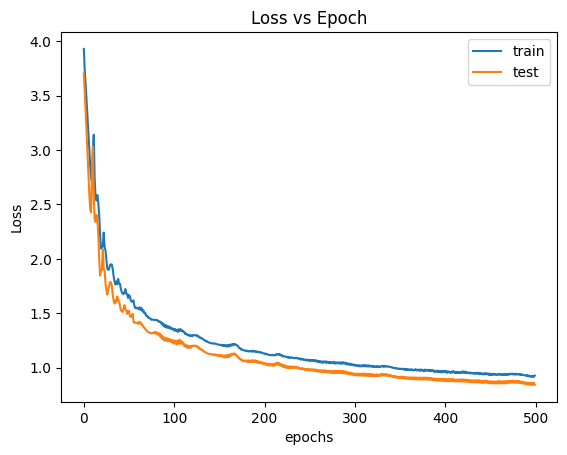

In [10]:
plt.plot(loss_list_train,label='train')
plt.plot(loss_list_test,label='test')
plt.title("Loss vs Epoch")
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Load the Model

In [13]:
params=torch.load('MLP_dropmodel.pt')
params.keys()

dict_keys(['W1', 'W2', 'b1', 'b2'])

## Train Test Accuracy

In [14]:
# train accuracy
Z1_etrain=X_etrain@params['W1']+params['b1']
A1_train=torch.relu(Z1_etrain)
Z2_etrain=A1_train@params['W2'] + params['b2']
Y_hat_etrain=softmax(Z2_etrain)
y_pred_etrain=torch.argmax(Y_hat_etrain,dim=1,keepdim=True)

train_acc=torch.sum(Y_etrain==y_pred_etrain)/Y_etrain.shape[0]


# test accuracy
Z1_etest=X_etest@params['W1']+params['b1']
A1=torch.relu(Z1_etest)
Z2_etest=A1@params['W2'] + params['b2']
Y_hat_etest=softmax(Z2_etest)
y_pred_etest=torch.argmax(Y_hat_etest,dim=1,keepdim=True)

test_acc=torch.sum(Y_etest==y_pred_etest)/Y_etest.shape[0]

print(f"Train Accuracy: {train_acc*100: .2f}%\
      \nTest Accuracy: {test_acc*100: .2f}%")

Train Accuracy:  76.58%      
Test Accuracy:  75.61%
